In [1]:
from sylber import Segmenter
import matplotlib.pyplot as plt
import soundfile as sf
import torchaudio
import torch
import librosa
from IPython.display import Audio

/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Extracting Sylber Units and Visualizing Similarity Matrix


In [2]:
# Loading Sylber
segmenter = Segmenter(model_ckpt="sylber")

Pre-trained checkpoint loaded


In [3]:
wav_file = "samples/sample.wav"

outputs = segmenter(wav_file)
# or
# outputs = segmenter(wav=wav)

In [4]:
wav,sr = sf.read(wav_file)

In [5]:
Audio(data=wav, rate=sr)

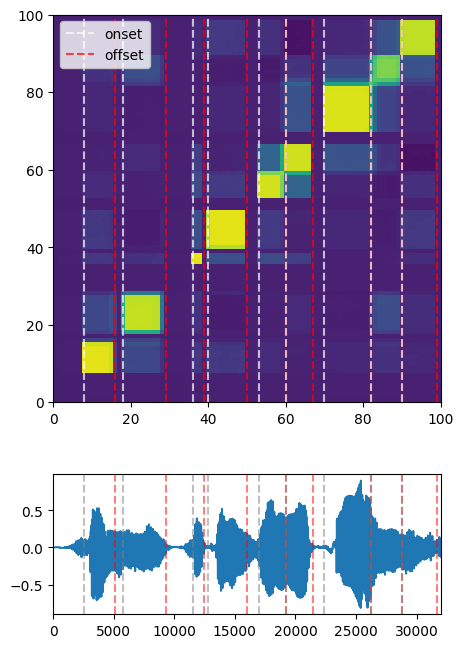

In [6]:
# The below plot is assuming sr is 16000 (but properly han
frame_num = 100

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1],},figsize=(5,8))
a0.imshow(outputs['hidden_states']@outputs['hidden_states'].T)
need_legend=True
for s,e in outputs['segments']:
    a0.axvline(s*50, color='white',ls='--',alpha=.7,label='onset')
    a0.axvline(e*50, color='red', ls='--',alpha=0.7,label='offset')
    if need_legend:
        a0.legend()
        need_legend = False
a0.set_xlim(0,frame_num)
a0.set_ylim(0,frame_num)
a1.plot(wav[:int(sr*frame_num/50)])
a1.set_xlim(0,int(sr*frame_num/50))
for s,e in outputs['segments']:
    a1.axvline(s*sr, color='gray',ls='--',alpha=0.5,label='onset')
    a1.axvline(e*sr, color='red', ls='--',alpha=0.5,label='offset')

### Sylber Units Reconstruction

In [7]:
from huggingface_hub import hf_hub_download

# Download checkpoint from Hugging Face
synth_ckpt = hf_hub_download(repo_id="cheoljun95/sylber", filename="synthesis_sylber.ckpt")

In [8]:
from sylber import SegmentSynthesis
import yaml
import torch
import numpy as np

# Load YAML configuration
with open('sylber_configs/sylber_resynthesis.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Initialize SegmentSynthesis with the YAML configuration
sylber = SegmentSynthesis(**config).cuda().eval()

# Load checkpoint
result = torch.load(synth_ckpt, map_location='cpu')
modified_state_dict = {k.replace('net.', ''): v for k, v in result['state_dict'].items()}
sylber.load_state_dict(modified_state_dict, strict=False)


outputs = segmenter(wav_file, in_second=False) # in_second is deactivate to get frame indices as segment outputs.

features = np.zeros(outputs['hidden_states'].shape)
with torch.no_grad():
    for (s,e), segft in zip(outputs['segments'], outputs['segment_features']):
        features[s:e] = segft[None,:]
        
# Perform resynthesis on non-quantized segments
features = torch.from_numpy(features).float().cuda().unsqueeze(0)
with torch.no_grad():
    resynth_outputs = sylber.resynthesize(features=features, steps=50, rand_scale=0.0)

## Encode & decode from wavform

#wav,sr = torchaudio.load(wav_file)
#wav = (wav-wav.mean())/wav.std()
#wav = wav.cuda()

#with torch.no_grad():
#    resynth_outputs = sylber.resynthesize(input_values=wav, steps=10, rand_scale=0., merge_threshold=0.8)

### Generate waveform using SPARC decoder

In [9]:
from sparc import load_model
import numpy as np
coder = load_model("en", device="cuda", use_penn=False) 

# For extracting voice identity (embedding and mean pitch level from reference wavefile.
# The token-to-speech model is generating speaker-agnostic articulatory features from Sylber tokens.
# Here, we are showing using the original audio, but it can be any arbitrary speaker.

sparc_features = coder.encode(wav_file)

art = resynth_outputs[0][0].cpu().numpy()
ema = art[:,:12]
pitch = np.exp(art[:,12:13])*sparc_features['pitch_stats'][0] # pitch_mean should be predefined
loudness = art[:,13:]
#loudness = (loudness-np.quantile(loudness,0.1)).clip(0)
resynth_wav = coder.decode(ema, pitch, loudness, sparc_features['spk_emb']) # spk_emb should be predefined

/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/home/cheoljun/anaconda3/envs/asp/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [10]:
Audio(data=resynth_wav, rate=coder.sr)